In [1]:
#!pip install --upgrade pandas numpy scikit-learn imbalanced-learn scipy xgboost seaborn matplotlib

In [3]:
import imblearn
import pandas as pd
import numpy as np
import sklearn
import scipy
import xgboost as xgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

for i in [pd, np, sklearn, scipy, imblearn, xgb, mpl, sns]:
    print(i.__name__, i.__version__)

pandas 2.1.2
numpy 1.26.1
sklearn 1.3.2
scipy 1.11.3
imblearn 0.11.0
xgboost 2.0.1
matplotlib 3.8.0
seaborn 0.13.0


# 문제 개요

**주제: 읽을 도서(to read) 목록을  예측**

유명 도서 전자상거래 회사에서 근무하는 Junior DataScientist 지희는 

읽을 도서(to read)여부 예측하는 모델을 개발하고자 합니다.

예측 결과를 활용하여 사용자에게 도서를 추천하는 시스템을 구상하고 있습니다.

지희가 도서 추천 프로젝트를 성공적으로 이끌기 위한 미션을 해봅니다.

**데이터셋 구성**

파일명: **books.csv**

도서 정보

|변수명|설명|타입|
|------|----|----|
|book_id|도서 번호|정수형|
|authors|저자|정수형|
|original_title|도서 원제목|문자형|
|pub_year|출간연도|실수형|
|genre|장르|문자형|
|children|유아 가부|정수형|

--------------------------------
파일명: **ratings.csv**

사용자의 도서 평점 데이터 

|변수명|설명|타입|
|------|----|----|
|user_id|사용자 ID|정수형|
|book_id|도서 번호|정수형|
|ratings|평점|정수형|

--------------------------------
파일명: **ratings_test.csv**

사용자의 도서 평점 테스트 데이터

|변수명|설명|타입|
|------|----|----|
|user_id|사용자 ID|정수형|
|book_id|도서 번호|정수형|
|ratings|평점|정수형|

--------------------------------
파일명: **to_read_sample.csv**

사용자별 to_read 도서 목록 샘플

|변수명|설명|타입|
|--|--------------|------|
|user_id|고객 번호|정수형|
|to_reads|도서 번호|문자형: 사용시 '\|'로 구분하여 정수형 리스트로 변환하여 사용|

---------------------------------
파일명: **to_read_kaggle.csv**

kaggle형에서 to_read 목록을 생성해야할 user_id

|변수명|설명|타입|
|--|--------------|------|
|user_id|고객 번호|정수형|


# 데이터 전처리

지희는 읽을 책에는 사용자의 선호도에 기반을 하여 성향을 파악하면 도움이 되리라 생각이 되어, 

사용자의 도서 평점 정보를 활용해 보면 어떨까 생각이 들어 평점 정보를 입수했습니다.

여기서 사용자의 선호도를 추출할 방법을 연구소에 문의한 결과 다음과 같은 가이드를 받았습니다.

-------------------------------

도서 평가데이터에 내재된 사용자별 속성과 도서별 속성을 n차원 실수 벡터로 추출하는 법을 알려 드립니다.

사용자별로 실수 벡터를 모아 (사용자수×n) 행렬로 나타냅니다. 각각의 벡터는 user_id를 통해 접근합니다.

|user_id|$u_0$|$u_1$|$u_1$|...|$u_n$|
|-------|--|--|--|---|--|
|1|0.251|0.1|0.03|...|0.15|
|4|0.08|0.15|0.01|...|0.8|
|...|...|...|...|...|...|
|53394|0.01|0.81|0.12|...|0.92|

※ 위 수치는 실제 수치와는 관계 없습니다.

* Hint user_id를 인덱스로한 pd.DataFrame 구조를 사용하는 것을 권장합니다.

도서별로 실수 벡터를 모아 (도서의 수×n) 행렬로 나타냅니다. 각각의 벡터는 book_id를 통해 접근합니다.

|book_id|$b_0$|$b_1$|$b_1$|...|$b_n$|
|-------|--|--|--|---|--|
|1|0.1|0.128|0.5|...|0.1|
|2|0.07|0.18|0.25|...|0.02|
|...|...|...|...|...|...|
|2355|0.08|0.11|0.02|...|0.05|

※ 위 수치는 실제 수치와는 관계 없습니다.

* Hint book_id를 인덱스로한 pd.DataFrame 구조를 사용하는 것을 권장합니다.


L2 규제(규제 계수 $\lambda$)가 있는 회귀모델 즉, Ridge 회귀모델을 아래의 OLS(Ordinary Least Square)를 통한 회귀계수 구하는 공식을 이용하여

사용자와 도서의 내재된 속성을 추출합니다. 



$\hat{\beta}=(X^TX + \lambda I)^{-1}X^Ty$, 

$X$는 입력 디자인행렬, $y$는 대상변수입니다. $I$는 n×n의 단위행렬(주대각 원소는 1이고 나머지는 0인 행렬)



추출 과정은 아래 **Step A-1~ 5**에서 설명합니다.


연구소에서 검토 결과 이 데이터셋에서는 **$n = 10$, $\lambda = 15$** 을 사용헀을 때, 

시각화를 통해 도서의 성질을 잘 반영하는 결과를 보였다고 합니다. 

구체적인 지표를 제시하지는 않아 미심쩍지만, 이 설정으로 추출을 진행합니다.

-----------------------------------------------


**Step A-1**

ratings.csv를 불러옵니다. (데이터셋 명: **ratings**)

In [5]:
df_ratings = pd.read_csv('ratings.csv')
display(df_ratings.info())
display(df_ratings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227788 entries, 0 to 227787
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  227788 non-null  int64
 1   book_id  227788 non-null  int64
 2   rating   227788 non-null  int64
dtypes: int64(3)
memory usage: 5.2 MB


None

,user_id,book_id,rating
0,5115,409,5
1,41322,41,5
2,13438,596,3
3,39116,60,3
4,8014,23,4


**Step A-2**

**user_coef**와 **book_coef**를 다음 초기화 루틴에 따라 초기화합니다.

**Step A-1**에서 불러온 **ratings** 데이터프레임의 변수명을 df_ratings로 했을 때, 기준으로 만든 가이드 입니다. 

Python:  user_coef, book_coef 초기화 루틴
```
np.random.seed(123)
n = 10
df_user_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['user_id'].nunique(), n)) * 1 / (n ** 0.5), 
    index=df_ratings['user_id'].unique(),
    columns=['u{}'.format(i) for i in range(10)]
)
df_book_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['book_id'].nunique(), n)) * 1 / (n ** 0.5), 
    index=df_ratings['book_id'].unique(),
    columns=['b{}'.format(i) for i in range(10)]
)
```


In [7]:
np.random.seed(123)
n = 10

# 0 ~ 1/sqrt(n) 임의의 수로(최적의 수렴을 위한 경험적으로 파악된 범위) 초기화 해줍니다.
df_user_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['user_id'].nunique(), n)) * 1 / (n ** 0.5), 
    index=df_ratings['user_id'].unique(),
    columns=['u{}'.format(i) for i in range(10)]
)
df_book_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['book_id'].nunique(), n)) * 1 / (n ** 0.5), 
    index=df_ratings['book_id'].unique(),
    columns=['b{}'.format(i) for i in range(10)]
)

display(df_user_coef.head())
display(df_book_coef.head())

,u0,u1,u2,u3,u4,u5,u6,u7,u8,u9
5115,0.220243,0.090485,0.071737,0.174341,0.227516,0.133798,0.310145,0.216562,0.152084,0.123998
41322,0.108522,0.230546,0.138689,0.018872,0.125873,0.233375,0.057709,0.055483,0.168091,0.168179
13438,0.200615,0.268614,0.229093,0.193223,0.228457,0.102129,0.114408,0.072183,0.092881,0.199532
39116,0.029126,0.137148,0.136251,0.156117,0.134659,0.098746,0.134824,0.282514,0.298570,0.158695
8014,0.197311,0.036562,0.100334,0.131180,0.273951,0.079201,0.152749,0.311661,0.164276,0.193814


,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
409,0.262438,0.097844,0.053097,0.275176,0.274501,0.071009,0.292345,0.165106,0.312427,0.273802
41,0.057463,0.213965,0.302129,0.022355,0.070824,0.292441,0.233511,0.028588,0.280410,0.067130
596,0.276948,0.051862,0.173178,0.110434,0.246806,0.297502,0.069824,0.299641,0.061945,0.024324
60,0.063258,0.256703,0.046376,0.073264,0.087374,0.089428,0.233503,0.265952,0.260564,0.045933
23,0.063401,0.004007,0.277435,0.309319,0.183181,0.051887,0.209688,0.164094,0.214495,0.213498


**Step A-3**

rating을 user_id로 구분합니다. 

구분된 rating셋에서 입력 변수는 **book_coef**행렬에서 book_id에 대응하는 벡터이고, 목적 변수인 rating 변수일 때,

Ridge 회귀모델의 회귀 계수를 위의 공식을 사용하여 구합니다.

예를 들어 user_id 가 1인 rating셋이 아래와 같다면,

|book_id|rating|
|-------|------|
|1|5|
|5|4|
|3|3|
|...|...|
|21|4|

user_id 1에 대한 Ridge 회귀모델을 구하기 위한 Design Matrix는

|$b_0$|$b_1$|$b_2$|...|$b_9$|rating|
|-----|-----|-----|---|-----|------|
|b(1,0)|b(1,1)|b(1,2)|...|b(1,9)|5|
|b(5,0)|b(5,1)|b(5,2)|...|b(5,9)|4|
|b(3,0)|b(3,1)|b(3,2)|...|b(3,9)|3|
|...|...|...|...|...|...|
|b(21,0)|b(21,1)|b(21,2)|...|b(21,9)|4|

가 됩니다. ※ b(i, j): book_coef에서 book_id=i의 j번째 요소입니다

각각의 구분된 rating셋에서 Ridge 회귀모델의 계수를 구하여 user_coef와 동일한 형태의 Matrix를 구합니다.

이를 **user_coef_next**라고 합니다.


Python함수 가이드
```
numpy.dot
numpy.eye
numpy.linalg.inv 활용 권장
```

힌트]


$Δu^2=\sum_{i∈User}{\sum_{j=0}^{j=9}[(u(i,j) - u2(i, j)]^2}$
※ u(i, j): user_coef에서 user_id=i의 j번째 요소입니다.

※ u2(i, j): user_coef_nex에서 user_id=i의 j번째 요소입니다

첫 번째 실행 때의 $Δu^2$는 39834.447 (넷째자리 반올림해서 셋째 자리 구함) 입니다.

Ridge 회귀식: $\hat{\beta}=(X^TX + \lambda I)^{-1}X^Ty$, 

In [22]:
n = 10 # 잠재 요소의 수
lam = np.eye(n) * 15 # 규제항

# Ridge 회귀 계수를 구하기 위한 함수입니다.
# X: 입력 Matrix, y 대상 값, lam 규제함 (단위행렬 × lambda)
def ridge(X, y, lam):
    gram_matrix = np.dot(X.T, X) + lam
    gram_inv = np.linalg.inv(gram_matrix)
    return np.dot(gram_inv, np.dot(X.T, y))

# 1. groupby(user_id) ~ apply를 통해서 user_id별로 구분된 DataFrame을 apply 함수에 전달받습니다.
# 2. df_book_coef에서 book_id에 해당하는 계수들을 가져와서 Ridge regression 입력 변수를 만듭니다.
# 3. 위에서 정의한 ridge함수를 통해 df_book_coef로 구성한 입력행렬과 타겟변수 rating  그리고 규제항을 전달합니다.
# 4. numpy array반환된 회귀계수들을 Series로 반환합니다. 이때 index를 df_user_coef의 컬럼값으로 해주어,
#    groupby ~ apply후에 결과값을 DataFrame으로 구성할때 컬럼값이 되도록 합니다.
df_user_coef_next = df_ratings.groupby('user_id').apply(
    lambda x: pd.Series(ridge(df_book_coef.loc[x['book_id']], x['rating'], lam), index=df_user_coef.columns)
)

# 문제에서 힌트로 제공한 차이값의 제곱들의 합을 확인하기 위해 구합니다.
delta_U = ((df_user_coef_next - df_user_coef) ** 2).sum().sum()

**Step A-4**

rating을 book_id로 구분합니다. 

구분된 rating셋에서 입력 변수는 **user_coef_next** 행렬에서 user_id에 대응하는 벡터이고, 목적 변수인 rating 변수일 때, 

Ridge 회귀모델의 회귀 계수를 위의 공식을 사용하여 구합니다.

book_id 가 2인 rating이 아래와 같다면,

|user_id|rating|
|-------|------|
|2|5|
|7|4|
|5|3|
|...|...|
|82|4|

book_id 2에 대한 Ridge 회귀모델을 구하기 위한 Design Matrix는

|$u_0$|$u_1$|$u_2$|...|$u_9$|rating|
|-----|-----|-----|---|-----|------|
|u2(2,0)|u2(2,1)|u2(2,2)|...|u2(2,9)|5|
|u2(7,0)|u2(7,1)|u2(7,2)|...|u2(7,9)|4|
|u2(5,0)|u2(5,1)|u2(5,2)|...|u2(5,9)|3|
|...|...|...|...|...|...|
|u2(82,0)|u2(82,1)|u2(82,2)|...|u2(82,9)|4|

가 됩니다. ※ u2(i, j)는 user_coef_next에서 user_id=i의 j번째 요소입니다

각각의 구분된 rating셋에서 Ridge 회귀모델의 계수를 구하여 book_coef와 동일한 형태의 Matrix를 구합니다.

이를 **book_coef_next**라고 합니다.


힌트]


$Δb^2=\sum_{i∈Book}{\sum_{j=0}^{j=9}[(b(i,j) - b2(i, j)]^2}$

※ b(i, j): book_coef에서 book_id=i의 j번째 요소입니다.

※ b2(i, j): book_coef_next에서 book_id=i의 j번째 요소입니다

첫 번째 실행 후의 $Δb^2$는 389.416 (넷째자리 반올림해서 셋째 자리 구함)입니다. 

In [23]:
# df_user_coef_next를 구하는 방법을 df_book_coef_next를 그대로 적용합니다.
df_book_coef_next = df_ratings.groupby('book_id').apply(
    lambda x: pd.Series(ridge(df_user_coef_next.loc[x['user_id']], x['rating'], lam), index=df_book_coef.columns)
)

delta_B = ((df_book_coef_next - df_book_coef) ** 2).sum().sum()
delta_B

389.4157081697885

**Step A-5**

```
user_coef = user_coef_next
book_coef = book_coef_next
```

으로 설정합니다.

**Step A-3~5**를 **모두 7번을 반복**합니다. 

마지막 실행시, 

$Δu^2$는 62.489, $Δb^2$는 15.764 (넷째자리 반올림해서 셋째 자리 구함) 

입니다.


최종 user_coef와 book_coef를 각각 **user_coef**, **book_coef** 셋이라고 칭합니다.

In [24]:
# Step A-2~4의 내용까지 포함하여 구현합니다.
n = 10
lam = np.eye(n) * 15

def ridge(X, y, lam):
    gram_matrix = np.dot(X.T, X) + lam
    gram_inv = np.linalg.inv(gram_matrix)
    return np.dot(gram_inv, np.dot(X.T, y))

for epoch in range(7):   
    df_user_coef_next = df_ratings.groupby('user_id').apply(
        lambda x: pd.Series(ridge(df_book_coef.loc[x['book_id']], x['rating'], lam), index=df_user_coef.columns)
    )

    df_book_coef_next = df_ratings.groupby('book_id').apply(
        lambda x: pd.Series(ridge(df_user_coef_next.loc[x['user_id']], x['rating'], lam), index=df_book_coef.columns)
    )

    delta_B = ((df_book_coef_next - df_book_coef) ** 2).sum().sum()
    delta_U = ((df_user_coef_next - df_user_coef) ** 2).sum().sum()

    df_user_coef = df_user_coef_next
    df_book_coef = df_book_coef_next

    print(epoch + 1, delta_B, delta_U)

1 389.4157081697885 39834.44735835226
2 218.9556119702082 2634.206159906778
3 86.67844871266631 926.662580254317
4 44.41470966620938 344.6120328321456
5 29.000772509975768 173.38267778892035
6 20.937716587018226 100.11840508703614
7 15.764150199685533 62.488700105216324


**Step A-6**

books.csv를 불러옵니다.(데이터셋명: **books**)

In [27]:
df_books = pd.read_csv('books.csv', index_col='book_id')
display(df_books.info())
display(df_books.head())

<class 'pandas.core.frame.DataFrame'>
Index: 687 entries, 1 to 2355
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   authors         687 non-null    object 
 1   original_title  680 non-null    object 
 2   pub_year        687 non-null    float64
 3   genre           679 non-null    object 
 4   children        687 non-null    object 
dtypes: float64(1), object(4)
memory usage: 32.2+ KB


None

,authors,original_title,pub_year,genre,children
book_id,,,,,
1,Suzanne Collins,The Hunger Games,2008.0,Adventure,no
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,Yes
3,Stephenie Meyer,Twilight,2005.0,Romance,no
4,Harper Lee,To Kill a Mockingbird,1960.0,Mystery,no
5,F. Scott Fitzgerald,The Great Gatsby,1925.0,Romance,no


**Step A-7**

**books**의 children을 소문자로 변환합니다.

chilren을 yes이면 1 no이면 0인 정수형 변수로 형변환 합니다.

In [32]:
df_books['children'] = (df_books['children'].str.lower() == 'yes').astype(int)

# 문제 1

**book_coef**, **books**를 이용하여 ratings에서 추출한 book_coef가 얼마나 books의 내용을 반영하는지 확인합니다.

**Step 1-1**

**books**에서 book_id가 2의 책의 저자(authors)와 원제목(ortiginal_title)은 J.K. Rowling / Harry Potter and the Philosopher's Stone

입니다.

**book_coef**에서 book_id 2와 유클리디언 거리가 가장 가까운 책 10개 중에서(book_id 2를 제외) 저자가 J.K. Rowling인 책의 수를 **A**, 

가장 거리가 가까책과의 거리를 **B**를 구합니다.

Python 함수 가이드
```
from scipy.spatial.distance import cdist

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [36]:
df_book_coef.loc[[2]]

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
book_id,,,,,,,,,,
2,0.917188,-0.565365,0.916848,0.704633,1.913799,0.452515,1.018715,1.668678,-1.240956,1.003572


In [55]:
from scipy.spatial.distance import cdist

s_nearest_10 = pd.Series(
    cdist(df_book_coef.loc[[2]], df_book_coef, metric='euclidean')[0], index=df_book_coef.index
).sort_values().iloc[1:11]

A = len(
    df_books.loc[
        s_nearest_10.index
    ].pipe(lambda x: x.loc[x['authors'] == "J.K. Rowling"])
)
B = s_nearest_10.iloc[0]
A, B

(7, 0.6151672842453714)

**Step 1-2**


books에서 각각 book_id에 해당하는  **book_coef**에서 벡터의 거리가 가장 짧은 book_id를 구합니다. (자신은 제외합니다.) 

이 파생변수명을 nearest_id합니다.

nearest_id를 구할 때의 벡터간의 거리는 다음 3가지를 사용해봅니다.

1. $\sqrt{\sum{(u_i-v_i)^2}}$

2. $1-\frac{u \cdot v}{{\|u\|}_2 {\|v\|}_2}$

3. $\sum{|u_i-v_i|}$

그리고 nearest_id의 저자(authors)를 파생 변수명 nearest_authors 라고 합니다.

nearest_id와 nearest_authors를 books에 추가하여 **books_near** 셋을 만듭니다.

**books_near**에서 저자(authors)가 한 번 등장하는 경우는 제외합니다.

nearest_authors와 authors가 같은 행의 비율(0~1 사이의 수)을 hit_rate라고 합니다. 

가장 hit_rate가 높은 경우의 제시한 거리의 번호를 **C**, hit_rate의 최대값을 **D**라고 합니다.

Python 함수 가이드
```
from scipy.spatial.distance import pdist, squareform

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [106]:
from scipy.spatial.distance import pdist, squareform

metrics = ['euclidean', 'cosine', 'cityblock']
hit_rates = list()

for metric in metrics:
    nearest_id = pd.DataFrame(
        squareform(pdist(df_book_coef, metric=metric)),
        index=df_book_coef.index,
        columns=df_book_coef.index
    ).apply(
        lambda x: x.loc[x.index != x.name].sort_values().index[0], 
    axis=0)
    nearest_author = df_books.loc[nearest_id, 'authors'].rename('nearest_author')
    
    df_books_near = df_books.copy()
    
    df_books_near['nearest_id'] = nearest_id
    df_books_near['nearest_author'] = nearest_author.values
    
    hit_rate = df_books_near.groupby('authors').filter(lambda x: len(x) > 1)\
        .pipe(lambda x: x['authors'] == x['nearest_author']).mean()
    hit_rates.append(hit_rate)

C = np.argmax(hit_rates) + 1
D = np.max(hit_rates)
hit_rates, C, D

([0.257372654155496, 0.24396782841823056, 0.257372654155496],
 1,
 0.257372654155496)

**Step 1-3**

**book_coef**와 **books**를 book_id를 기준의로 inner 방법으로 결합하여 **book_ind**를 만듭니다.


**book_ind** 의 변수 b0, b1, ..., b9 각각이 children에 대하여 독립여부를 다음 절차에 따라 검정을 합니다.

즉 10번의 독립성 검정을 하여, 독립이 아닌 변수의 수를 구하여 **E**라고 합니다. (유의 수준 5%)

b를 b0, b1, ... b9 중 검정 대상이 되는 임의 변수를 말합니다.

$H_0$: b 와 children은 독립입니다. 

$H_1$: b 와 children은 독립이 아닙니다.


**검정 절차**

children으로 b를 구분하여 두 개의 표본 집단을 만듭니다.

구분한 각각의 표집이 Kolmogorov-Smironof 검정을 사용하여 정규 분포를 따르는지 판단합니다. (**유의 수준: 1%**)

b가 정규 분포를 따른 다면, t-검정을 사용하여 독립성 검정을 합니다. 

t-검정 시 등분산 여부는 bartlett 검정의 결과를 통하여 정합니다. (유의 수준 5%)

b가 정규 분포를 따르지 않는 다면, mann-whitney U 검정을 사용합니다. 이 때 대립가설은 양측 검정으로 설정을 명시합니다.


Python 함수 가이드
```
import scipy.stats 에 있는 기능을 활용합니다.

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

In [120]:
df_book_ind = df_books.join(df_book_coef, how='inner')
df_book_ind.head()

,authors,original_title,pub_year,genre,children,nearest_id,nearest_author,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
book_id,,,,,,,,,,,,,,,,,
1,Suzanne Collins,The Hunger Games,2008.0,Adventure,0,17,Suzanne Collins,0.138815,-0.389481,1.335726,1.396937,0.837018,-0.180358,1.813663,1.541558,0.622059,-0.149148
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1,23,J.K. Rowling,0.917188,-0.565365,0.916848,0.704633,1.913799,0.452515,1.018715,1.668678,-1.240956,1.003572
3,Stephenie Meyer,Twilight,2005.0,Romance,0,52,Stephenie Meyer,0.209286,-0.769423,0.596333,0.173773,0.168269,1.272244,-0.254729,3.273716,2.108776,-1.761374
4,Harper Lee,To Kill a Mockingbird,1960.0,Mystery,0,225,John Steinbeck,1.839442,-0.046629,1.557281,0.352157,0.312667,0.520326,1.461590,0.390590,-0.252235,1.397125
5,F. Scott Fitzgerald,The Great Gatsby,1925.0,Romance,0,595,John Knowles,1.071913,-0.080170,2.220363,-0.161523,0.682047,1.336947,-0.414038,0.105487,-0.059212,2.034095


In [132]:
df_children_b = df_book_ind.groupby('children')[X_b].agg(list)
X_b = ['b{}'.format(i) for i in range(0, 10)]
df_norm = df_children_b.map(
    lambda x: kstest(
        zscore(x, ddof=1),
        norm.cdf,
        alternative='two-sided'
    ).pvalue
)
t_cols = (df_norm >= 0.01).all(axis=0).pipe(lambda x: x.loc[x].index.tolist())
m_cols = (df_norm >= 0.01).all(axis=0).pipe(lambda x: x.loc[~x].index.tolist())
t_cols, m_cols

In [156]:
from scipy.stats import ttest_ind, bartlett

E = len(
    pd.concat([
        df_children_b[t_cols].apply(lambda x: ttest_ind(x[0], x[1], equal_var=(bartlett(x[0], x[1]).pvalue >= 0.05)).pvalue, axis=0),
        df_children_b[m_cols].apply(lambda x: mannwhitneyu(x[0], x[1], alternative='two-sided').pvalue, axis=0)
    ]).pipe(lambda x: x.loc[x < 0.05])
)
E

8

**Step 1-4**

**books**에서 authors 변수의 수준별 빈도수를 구하여, 수준의 행의 수가 6개 이상 행들을 뽑아냅니다.

**books**에서 뽑아낸 행들과 **book_coef**를 book_id를 기준으로 inner 방법으로 결합합니다. (데이터셋명: **books_tsne**)

In [160]:
df_books_tsne = df_books.groupby('authors').filter(lambda x: len(x) >= 6).join(
    df_book_coef, how='inner'
)
df_books_tsne.head()

,authors,original_title,pub_year,genre,children,nearest_id,nearest_author,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
book_id,,,,,,,,,,,,,,,,,
2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,1,23,J.K. Rowling,0.917188,-0.565365,0.916848,0.704633,1.913799,0.452515,1.018715,1.668678,-1.240956,1.003572
7,J.R.R. Tolkien,The Hobbit or There and Back Again,1937.0,Fantasy,1,19,J.R.R. Tolkien,0.354365,0.497085,0.878341,-0.874002,2.765196,1.102908,1.327373,0.618805,0.627838,-0.386601
9,Dan Brown,Angels & Demons,2000.0,Thriller,0,26,Dan Brown,0.766320,1.441816,1.839474,0.866266,0.499720,0.421170,-0.340373,1.818877,-1.366579,-1.119477
10,Jane Austen,Pride and Prejudice,1813.0,Romance,0,76,Jane Austen,2.648726,0.174986,0.277345,-1.082401,1.065806,0.502501,1.418985,1.571153,-0.143763,0.558271
18,J.K. Rowling,Harry Potter and the Prisoner of Azkaban,1999.0,Fantasy,1,24,J.K. Rowling,0.777195,-0.629044,0.767708,1.138114,1.846045,0.560648,0.985656,1.528528,-0.793126,0.846061


**Step 1-5**

(**books_tsne** 사용) book_coef와 저자의 성향이 어떻게 반영이 되었지는 확인하기 위해, 

입력변수를  $b_0$, $b_1$, ..., $b_9$를 TSNE 모델을 사용하여 2개의 성분으로 줄입니다. 

TSNE 모델을 학습한 후의 원래의 공간과 임베딩 공간과의 결합분포(Joint Distribution)간의 Kullback-Leibler Divergence **F**라고 합니다.

Python 함수 가이드
```
from sklearn.manifold import TSNE
random_state=123, method='exact', perplexity=5
```

In [168]:
from sklearn.manifold import TSNE
X_tsne = ['b{}'.format(i) for i in range(10)]
tsne = TSNE(n_components=2, random_state=123, method='exact', perplexity=5)
tsne.fit(df_books_tsne[X_tsne])

F = tsne.kl_divergence_
F

0.4007568162129171

**Step 1-6, Optional**

위에서 구한 TSNE 임베딩에서 book_coef와 authors와의 연관성을 확인할 수 있는 시각화를 해봅니다.

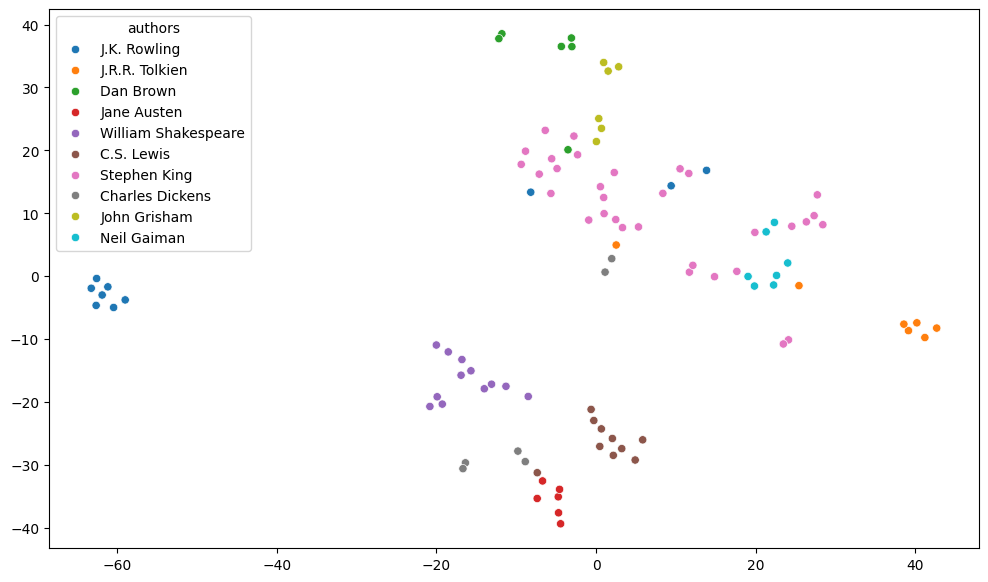

In [172]:
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x = tsne.embedding_[:, 0],
    y = tsne.embedding_[:, 1],
    hue = df_books_tsne['authors']
)
plt.show()

**Step 1-7, Optional**

book_coef  데이터셋을 다음과 같은 형식으로 tab으로 분리된 출력 파일 두 개를 만듭니다.

------------------------------------------------------------
**book_coef.tsv**

|$b_0$|$b_1$|$b_2$|...|$b_9$|
|-----|-----|-----|---|----|
|b(1, 0)|b(1, 1)|b(1, 2)|...|b(1, 9)|
|b(2, 0)|b(2, 1)|b(2, 2)|...|b(2, 9)|
|...|...|...|...|...|
|b(2355, 0)|b(2355, 1)|b(2355, 2)|...|b(2355, 9)|


Python 함수 가이드
```
pd.DataFrame.to_csv
sep='\t', header=None, index=None

```
---------------------------------------------------------------
**books.tsv**

|authors|original_title|genre|pub_year|children|
|-------|--------------|-----|--------|--------|
|Suzanne Collins|The Hunger Games|2008.0|Adventure|0|
|J.K. Rowling|Harry Potter and the Philosopher's Stone|1997.0|Fantasy|1|
|...|...|...|...|...|
|George Eliot|Silas Marner: The Weaver of Raveloe|1861.0|Drama|0|

original_title에 결측치는 'Unknown'으로 바꾸어 저장합니다. (books 데이터셋의 내용은 바꾸지 않습니다.)

Python 함수 가이드
```
pd.DataFrame.to_csv
sep='\t', index=None, header=None

```
----------------------------------------------------

[Embedding Projector](https://projector.tensorflow.org/)에 접속합니다.

우측에 회색 바탕의 Load 버튼을 클릭하면 

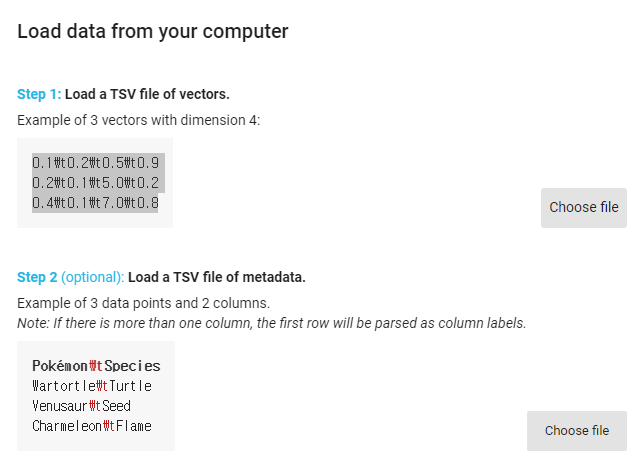

이미지가 뜨는데요, 

Step1에는 book_coef.tsv 

Step2에는 books.tsv

을 전달합니다.

In [176]:
df_book_coef.to_csv('book_coef.tsv', sep='\t', index=None, header=None)
df_books[['original_title']].to_csv('books.tsv', index=None, header=None)

# 식사 시간: ~ 13:05

# 문제 2

**user_coef**에 사용자의 성향을 반영하고 있는지, **user_coef**를 입력으로하는 예측 모델을 만들어 확인합니다.

사용자의 유형을 분류를 하기 위해,

**ratings**에 **books**에서의 genre 정보를 가져와서, 사용자별로  genre 별로 평가한 내역을 바탕으로 군집을 만듭니다.

**user_coef**의 u0, u1, ..., u9 변수만으로 사용자가 어떤 유형에 속하는 지에 대한 분류 모델을 만들어 성능 검증합니다.

이를 통해 사용자 유형을 파악할 만한 정보가 **user_coef**에 있는 지를 봅니다.

**Step2-1**

**books**에서 genre가 

Adventure, Comedy, Biography, Fantasy, Horror, Mystery, Romance, Sci-Fi, Thriller, Drama

인 행들만을 취하고, book_id와 genre 열만을 선택하여  **books2**를 만듭니다.

**ratings**와  **books2**를 book_id를 기준으로 inner 방식으로 결합하여 **ratings2**셋을 만듭니다.


**Step2-2**

**ratings2**에서 사용자(user_id)별로 평점을 남긴 장르의 비율을 구하여 아래와 같은 데이터프레임으로 만들고,  

user_id를 기준으로 오름차순 정렬한 데이터프레임을 **user_ratings**라고 합니다.

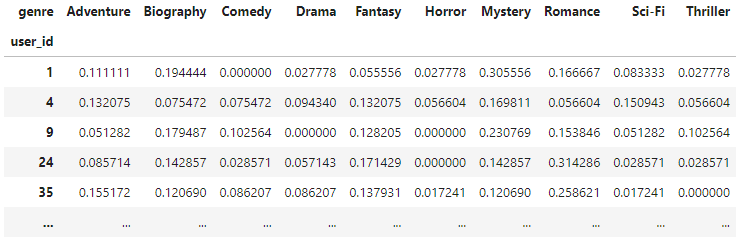

**Step 2-3**

**user_ratings** 에서 사용자가 평가를 남긴 도서의 장르의 비율로 K-Means 군집화를합니다.

클러스터의 수를 3에서 7사이 중에서 실루엣 스코어(Silhouette Score)를 기준으로 가장 좋은 결과를 보이는

K-Means 모델을 선택합니다.

입력 변수: Adventure, Biography, Comedy, Drama, Fantasy, Horror, Mystery, Romance, Sci-Fi, Thriller

모델 평가 지표: 
    
 $s_i = \frac{(b_i - a_i)}{max(a_i, b_i)}$, 
  
 $a_i$: i번째 샘플이 속한 클러스터 내의 다른 샘플과의 거리간의 평균, 
 
 $b_i$: i번째 샘플이 속하지 않은 가장 인접한 클러스터의 샘플들과의 거리의 평균
  
 $Silhouette\_Score = \frac{1}{N}\sum_{i=1}^{n}s_i$

python 함수가이드
```
from sklearn.cluster import KMeans
    init = 'random', n_init= 100, random_state=123 설정하여 사용합니다.

from sklearn.metrics import silhouette_score

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.

```

**Step 2-4**

**Step 2-3**에서 선택한 K-Means 모델과 user_ratings를 통해 user_id의 소속 군집을 구합니다.

**user_coef**의 user_id에 대응이 소속 군집을 파생변수 명 target을 **user_coef**에 포함시켜, 

새로운  **user_coef2** 데이터프레임을 만듭니다.

**Step 2-5**

**user_coef2** 의 u0, u1, ..., u9 변수를 표준화하여 동일한 변수를 사용하여 **user_coef2**에 저장합니다.

**user_coef2**는 user_id 기준으로 오름차순 정렬을합니다.

python 함수가이드
```
변수의 표준화는 

from sklearn.preprocessing 에 있는 기능을 활용합니다.

기본 설정을 사용합니다.

```

**Step 2-6**

**user_coef2**에서,

5겹 계층적교차검증(5-Fold Stratified Cross-Validation)으로 아래 4개의 모델(**Step 2-6-1~4**)에 대한 

5개의 겹외셋(Out-of Fold Set)에 대한 성능의 평균을 구하여 모델의 성능을 측정합니다.

측정한 모델의 성능을 첫번째 모델(**Step 2-6-1**)은 **A**, 

두번째 모델(**Step 2-6-2**)은 **B**, 

세번째 모델(**Step 2-6-3**)은 **C**, 

네번째 모델(**Step 2-6-4**)은 **D**로 합니다.

입력변수: u0, u1, ..., u9

대상변수: target

성능지표: $Accuracy=\frac{TP + TN}{TP + TN + FP + FN}$

        TP: True Positive 수, TF: True Negative 수, FP: False Positive 수, FN: False Negative 수
        
Python 가이드
```
from sklearn.model_selection import StratifiedKFold을 활용합니다.
random_state=123, shuffle=True
문제에세 제시한 요건외에는 기본 설정을 사용합니다.
```

**Step 2-6-1**

**1. Support Vector 분류 모델**
    
   모델 설정: kernel function: $exp(-0.1\cdot||x-x'||^2)$
   
Python 가이드
```
from sklearn.svm import SVC
probability=True, C=0.1, random_state=123
문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

**Step 2-6-2**

**2. 로지스틱 회귀 모델**

   모델 설정: l2 규제를 사용합니다. 규제 계수의 역수: 0.1
   
Python 가이드
```
from sklearn.linear_model import LogisticRegression
random_state=123, solver='lbfgs'
문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```


**Step 2-6-3**

**3. 신경망 분류 모델**

   모델 설정: 
   
    최적화 루틴의 최대 반복 횟수: 500회

    은닉층 수: 2, 첫번째 은닉층 유닛수: 8개, 두번째 은닉층 유닛수: 4개
    
    은닉층의 활성화 함수
    
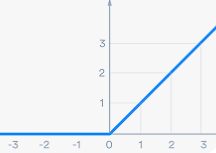
    
Python 함수 가이드
```
from sklearn.neural_network import MLPClassifier
random_state=123
문제에서 제시한 요건외에는 기본 설정을 사용합니다.
```

**Step 2-6-4**

**4. Voting 앙상블 분류 모델**

모델 설정:

    모델 구성은 위에서 제시한 1(Step 2-6-1), 2(Step 2-6-2), 3(Step 2-6-3)의 모델입니다.
  
    부드러운(Soft) Voting 방법 사용

Python 함수 가이드
```
from sklearn.ensemble import VotingClassifier
문제에서 제시한 요건외에는 기본 설정을 사용합니다.
```

# 문제 3

Junior DataScientist 지희는 프로젝트에서 추출한 성분들이 유효하다는 내용을 타부서에 공유를 했습니다.

이 발표를 들은 고객관리 부서는 다음과 같은 부탁을 했습니다.

노약자나 임산부를 위해 노약자나 임산부에 적합하지 않는 내용여부를 총 3단계로 표시해 줍니다. 

현재 이 기준은 장르가 Thriller나 Horror일 경우 Level 2, 그 외는 어린이용이면 0 아니면 1로 표시를 합니다.

장르 정보들이 정확하지 않거나 비어 있는 것이 많아 Level을 구분해 주는 기능을 검토해주세요.

이 과제를 수행해봅니다.

**Step3-1**

**books**와 **book_coef**를 book_id를 결합하여 **genre** 셋을 만듭니다. 

**Step3-2**

**genre**셋에서 genre가 Adventure, Comedy, Biography, Fantasy, Horror, Mystery, Romance, Sci-Fi, Thriller, Drama 인 행들만을 뽑아,

**level_train**셋을 만듭니다. 그 외의 행들로는 **level_test**셋을 만듭니다.

**Step3-3**

**level_train** 에서 genre에 따라 b0 ~ b9의 평균이 차이 여부를 분산분석(ANOVA)을 통해 살펴 보고자 합니다.

b0, b1, ..., b9 각각은 genre에 따라 정규분포를 따르고, 등분산임을 가정합니다.

$H_0$: genre에 따라 $b_i$의 평균은 같다.

$H_1$: genre에 따한 $b_i$의 평균은 다르다.

i가 0에서 9까지 10번의 분산분석을 하고, 가장 큰 pvalue를 **A**라고 합니다.

Python 함수 가이드
```
from scipy.stats 에서 제공하는 기능을 활용합니다.
문제에서 제시한 요건외에는 기본 설정을 사용합니다.
```

**Step3-4** 

**level_train**에 다음 조건에 맞게 정수형 파생변수 level을 생성합니다.

```
if genre == Horror or genre == Thriller then 2
else if children == 1 then 0
else if children == 0 then 1
```

**Step3-5**

**level_train**셋을 5조각으로 나누어 교차검증셋을 구성합니다.

5조각으로 나누는 방법은 level 별로 book_id순으로 0에서 시작하여 1씩 증가하는 일련번호를 만들고, 

첫번째셋은 일련번호를 5로 나누어 나머지가 0인 행들로 구성합니다.

두번째셋은 일련번호를 5로 나누어 나머지가 1인 행들을 구성합니다.

...

다섯째셋은 일련번호를 5로 나누어 나머지가 4인 행들을 구성합니다.


**Step3-6**

XGBoost 모델의 하이퍼파라미터(Hyper-Parameter)를 탐색하여 성능을 최적화 하고자 합니다.

하이퍼파라미터는 그리드 탐색(Grid Search)을 사용합니다.

하이퍼파라미터의 대상은 아래와 같습니다.

|하이퍼파라미터|탐색 대상 변수|
|--------|-----|
|트리의 최대깊이|3, 4, 5|
|트리의 수|300, 500, 800|


**성능 평가 과정**

**Step3-4**에서 구분한 5개의 셋을 첫번째셋 부터 다섯째셋까지 차례대로 검증셋(Out of foldset, 겹외셋)으로 총 5번의 검증을 다음과 같이 합니다.

각각의 검증 단계에서 train셋은 book_id를 기준으로 정렬을합니다. 

train셋은 SMOTE 알고리즘으로, 

대상변수의 빈도수가 가장 높은 클래스를 제외하고 나머지 클래스를 가장 높은 빈도수가 되도록 샘플링합니다. 

SMOTE를 통한 Oversampling한 train셋으로 학습을하고 검증셋으로 성능을 평가합니다.

5개의 검증셋의 성능지표의 평균을 Grid Search의 선택 기준으로 합니다.


입력변수: b0, b1, ~ b9과 children 을 나열한 순서에 맞춥니다.

대상변수: level

성능지표: Macro Recall

Python 함수가이드

```
import imblearn.over_sampling 
에서 제공하는 기능 활용합니다. random_state=123으로 설정합니다.

import xgboost as xgb
에서 제공하는 기능을  활용합니다, learning_rate=0.01, random_state=123

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```

최적의 파라미터의 트리의 깊이를 **B**, 트리의 수를 **C**, 그리고 이 경우의 5개 검증셋의 성능지표의 평균 **D**로 합니다.

**Step3-7**

**level_train**에 SMOTE 알고리즘으로 

대상변수의 빈도수가 가장 높은 클래스를 제외하고 나머지 클래스를 가장 높은 빈도수가 되도록 샘플링하여, 

**level_smote**를 만듭니다.

XGBoost 모델을 트리의 최대깊이는 **B**, 트리의 수는 **C**로 하여, **level_smote**을 학습합니다.


입력변수: b0, b1, ~ b9과 children 을 나열한 순서에 맞춥니다.

대상변수: level


학습한 모델로 **level_test**의 level을 예측하고, 

level의 예측결과가 2인 빈도수를 구하여 **E**로 합니다.


Python 함수가이드
```
import imblearn.over_sampling 
에서 제공하는 기능 활용합니다. random_state=123으로 설정합니다.

import xgboost as xgb
에서 제공하는 기능을  활용합니다, learning_rate=0.01, random_state=123

문제에서 제시한 요건 외에는 기본 설정을 사용합니다.
```


# 문제 4

전처리 단계에서 평점 데이터를 이용하여 사용자 별 특성(**user_coef**)과 도서 별 특성(**book_coef**)을 추출했습니다. 

전처리 단계에서 추출한 user_coef와 book_coef과 이 선형모델이 얼마나 평점을 잘 예측하는지 확인해봅니다.


**Step4-1** 

'ratings_test.csv'를 읽어 옵니다(**ratings_test**셋이라고 합니다.).

**Step4-2**

ratings에서, user_id별 rating의 평균을 rating_user라는 변수명으로 **user_rating_mean** Series를 만듭니다

book_id별 rating의 평균을 rating_book라는 변수명으로 **book_rating_mean** Series를 만듭니다.

**Step4-3**

**ratings**에서 **user_rating_mean**과 user_id를 기준으로 결합하고, **book_rating_mean**은 book_id를 기준으로 결합하여 **ratings4** 셋을 만듭니다 

**ratings_test**에서 **user_rating_mean**과 user_id를 기준으로 결합하고, **book_rating_mean**은 book_id를 기준으로 결합하여 **ratings4_test**셋을 만듭니다,


**Step4-4**

**rating4**에서 α를 0과 1사이(경계 포함)에서 0.01 간격으로, 총 101개의 α를 대상으로

아래와 같이 rating_prd를 구해볼 때, 

최적의 RMSE를 보이는 alpha를 **A**라고하고, 

그 때의 RMSE를 **B**라고 합니다.

$ rating\_prd_i = \alpha \cdot rating\_user_i + (1 - \alpha) \cdot rating\_book_i $ 

$ RMSE = \sqrt{\frac{1}{N_{rating4}}\sum_{i∈ratings4}{\left(rating_i-rating\_prd_i\right)^2}}$

- $N_{rating4}$: **rating4**의 행의 개수

**Step4-5**

**Step4-4** 에서 구한 A로 **ratings4_test**의 rating_prd를 구하여, RMSE를 구하여 **C**라고 합니다.

$ RMSE = \sqrt{\frac{1}{N_{rating4\_test}}\sum_{i∈ratings4\_test}{\left(rating_i-rating\_prd_i\right)^2}}$

- $N_{rating4\_test}$:은 **ratings4_test**의 행의 개수

**Step4-6**

전처리 과정을 분석을 하면, 

사용자별 **user_coef**는 rating이 대상변수인 선형회귀 모델의 계수이고, 

**book_coef**는 이 모델의 입력 변수라고 할 수 있습니다.

이를 아래 식으로 표현할 수 있습니다.

$rating(user\_id, book\_id) = b(book\_id, 0) \cdot u(user\_id, 0) + b(book\_id, 1) \cdot u(user\_id, 1) + ... +  b(book\_id, 9) \cdot u(user\_id, 9)$

- b(book_id, i): **book_coef**에서 book_id의 i번째 계수

- u(user_id, j): **user_coef**에서 user_id의 j번째 계수


**ratings4_test**에 rating_als 파생 변수를 생성하고 rating과 RMSE를 구하여 **D**라고 합니다.

$ RMSE = \sqrt{\frac{1}{N_{rating4\_test}}\sum_{i∈ratings4\_test}{\left(rating_i-rating\_als_i\right)^2}}$

- $N_{rating4\_test}$:은 **ratings4_test**의 행의 개수

# 문제 5

Senior Data Scientist 지희는 사용자마다 to_read로 선정한 book_id를 예측 로직의 Baseline을 구하고자 합니다.

실제로 to_read로 선택한 샘플들을 제공 받았습니다. (to_read_sample.csv) 

사용자(user_id)가 평가를 했던 도서는 to_read에 선택이 되지 않습니다.

즉, 사용자(user_id)가 평가했던 도서(book_id)는 해당 사용자의 to_reads에는 존재하지 않습니다.

사용자 마다 to_read로 선정할 book_id를 리스트들를 만들어서, 평가하는 지표는 MAP@4를 성능을 측정해봅니다.


**Step5-1**

**ratings**와 **ratings_test**를 행을 방향으로 합쳐서 **ratings_all** 셋을 만듭니다.

**Step5-2**

to_read_sample.csv 불러옵니다. 이 셋을  **to_read_sample** 데이터셋이라고 합니다.

**to_read_sample**의 to_reads 컬럼은 '|'으 로 구분하며 복수의 book_id를 나타냅니다. 문자열로 되어 있는 to_read를 '|'으로 구분하여 

정수형의 리스트로 변환하여 동일 변수명으로 to_reads에 요소 각각이 정수형 리스트인 변수로 만듭니다.

**Step5-3** 

 **to_read_sample** 있는 사용자별(user_id) to_read 후보 bood_id 리스트를 아래 가이드에 맞춰 제작합니다.
 
1. ratings_all에서 book_id별로 rating을 평균을 구하여, rating_book_mean Series를 만듭니다.

2. ratings_book_mean에서 평균 ratings이 높은 것을 우선으로 사용자(user_id) 별로 4개의 book_id를 포함하는 예상 to_read를 만듭니다.

> ※ 주의: 이 때, user_id 별 to_read 후보 book_id 리스트를 만들 때에는 **ratings_all**에서 user_id의 평점 내역에 있는 book_id들은 제외하고 4개를 만드는 겁니다.
 
위의 기준으로 **to_read_sample** 있는 user_id 별로 실제로 to_read에 선택했던 book_id 리스트와

to_read 후보 book_id 리스트를 만들어 MAP@4를 구하여 **A**라고 합니다.


- 대상 지표

$MAP@4 = \frac{1}{|U|}\sum_{u∈U}\frac{1}{min(m_u,4)}\sum_{k=1}^{min(n_u,4)}Precision_{u}(k) \cdot Correct_{u}(k)$

$U$는 user_id 집합

$m_u$는 user_id가 $u$인 사용자의 to_read 수

$n_u$은 $u$대상으로 to_read로 선택할 것이라고 예상한 도서 목록수.

$u$를 대상으로 $Precision_u(k)$ k번째 to_read까지의 Precision, 
      $Correct_u(k)$  예상한 to_reads의 k번째 도서가 실제로 to_reads에 있다면, 1 아니면 0


Ex) user_id 가 9인 사용자가 실제로 to_read 로 선택한  도서 ID [230, 895, 112]

$m_9 = 3$, 

user_id 가 9인 사용자에 대한 예측 도서리스트가 [1, 230, 4, 895] 라면, 

$n_9 = 4$

|K|1|2|3|4|
|-|-|-|-|-|
|Precision_9(K)|0/1|1/2|1/3|2/4|
|Correct_9(K)|0|1|0|1|

**Step5-4** 

**to_read_sample** 있는 사용자별(user_id)는 to_read 후보 bood_id 리스트를 아래 가이드에 맞춰 제작합니다.

1. ratings_all에서 book_id별 빈도수를 구하여, **rating_book_count** Series를 만듭니다.

2. **rating_book_count**에서 ratings 수가 높은 것을 우선으로 사용자(user_id) 별로 4개의 book_id를 포함하는 예상 to_read를 만듭니다.

> ※ 주의: 이 때, user_id 별 to_read 후보 book_id 리스트를 만들 때에는 **ratings_all**에서 user_id의 평점 내역에 있는 book_id들은 제외하고 4개를 만드는 겁니다.
 
위의 기준으로 **to_read_sample** 있는 user_id 별로 실제로 to_read에 선택했던 book_id 리스트와

to_read 후보 book_id 리스트를 만들어 MAP@4를 구하여 **B**라고 합니다.

# 문제 6

이 업무를 맡은 지희는 사용자의 평점(rating)은 낮아도 사용자들이 읽은 책이라, 관심을 보인 것이라고 생각을 했습니다. 

즉 아무리 평점이 낮아도, 읽지 않은 책보다는 사용자의 관심이 있는 것이라는 겁니다.

평가의 평균이 높은 책 중의 상당수는 평가수가 적은 책이 상당수를 이루고 있다는 점에서, 

평가는 사용자가 책의 선호도를 온전히 나타낼 수 없다고 생각이 들었습니다.

to_read를 예측하기 위한 다른 모델을 Senior DataScientist 재윤과 논의 끝에, 다음 모델을 생각했습니다.
```

평가를 한 책은 책을 읽음, 평가를 하지 않은 책은 책을 읽지 않음으로 하여 책을 읽음 or 책을 읽지 않음 문제로 바꾸어 생각해보자는 것이다.
```

이를 위해, 전처리 단계의 모델을 응용하여 다음과 같은 모델을 설계했습니다. 

전처리 단계에서 특성을 추출한 방법을 다음과 같이 응용합니다.


1. 아래와 같이 각각의 사용자와 도서를 벡터로 나타내어 Matrix로 나타냅니다.

사용자별로 실수 벡터를 모아 (사용자수×n) 행렬로 나타냅니다. 각각의 벡터는 user_id를 통해 접근합니다. (**user_coef2**)

|user_id|$u_0$|$u_1$|$u_1$|...|$u_n$|
|-------|--|--|--|---|--|
|1|0.251|0.1|0.03|...|0.15|
|4|0.08|0.15|0.01|...|0.8|
|...|...|...|...|...|...|
|53394|0.01|0.81|0.12|...|0.92|

※ 위 수치는 실제 수치와는 관계 없습니다.

* Hint user_id를 인덱스로한 pd.DataFrame 구조를 사용하는 것을 권장합니다.

도서별로 실수 벡터를 모아 (도서의 수×n) 행렬로 나타냅니다. 각각의 벡터는 book_id를 통해 접근합니다. (**book_coef2**)

|book_id|$b_0$|$b_1$|$b_1$|...|$b_n$|
|-------|--|--|--|---|--|
|1|0.1|0.128|0.5|...|0.1|
|2|0.07|0.18|0.25|...|0.02|
|...|...|...|...|...|...|
|2355|0.08|0.11|0.02|...|0.05|

※ 위 수치는 실제 수치와는 관계 없습니다.

* Hint user_id를 인덱스로한 pd.DataFrame 구조를 사용하는 것을 권장합니다.

아래처럼 사용자 user_id가 도서 book_id를 읽을 Logit을 아래와 같이 정의합니다.

$Logit(user\_id, book\_id) = b(book\_id, 0) \cdot u(user\_id, 0) + b(book\_id, 1) \cdot u(user\_id, 1) + ... +  b(book\_id, n) \cdot u(user\_id, n)$

- b(book_id, i): **book_coef2**에서 book_id의 i번째 계수

- u(user_id, j): **user_coef2**에서 user_id의 j번째 계수

$\sigma(x)=\frac{1}{1 + e^{-x}}$

$\hat{y}(user\_id, book\_id) = \sigma(Logit(user\_id, book\_id))$


위와 같이 절편이 없는 로지스틱 회귀모델의 형태를 응용한 모델을 구상하여 **book_coef2**, **user_coef2**를 구합니다.

**Step6-1**

**ratings_all**에서 행은 user_id, 열은 book_id 이고, rating에 user_id와 book_id에 내역이 있으면 1, 없으면 0인 데이터프레임을 만듭니다.

행은 user_id에 대해서 오름차순으로 열은 book_id에 대해서 오름차순으로 구성합니다. 이 데이터셋을  **read**라고 칭합니다.

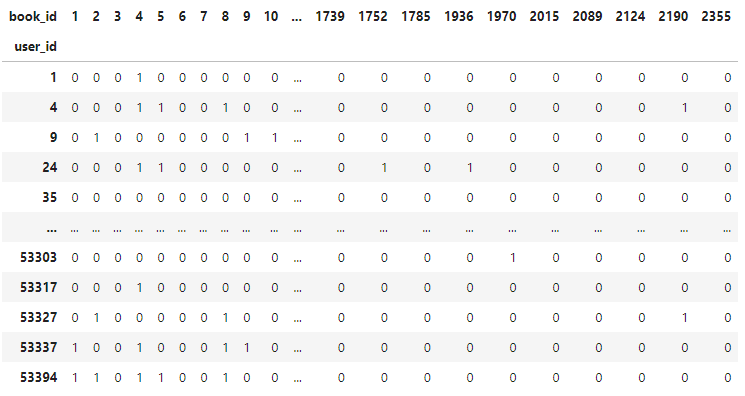


Python 함수가이드 
```
pd.crosstab
```

**Step 6-2**

n = 64 으로 하고

**book_coef2**와 **user_coef2**를 아래 루틴으로 초기화 합니다.

**Step 6-1**에서 불러온 **read**의 변수명을 df_read로 했을 때, 기준으로 만든 루틴 입니다. 

Python: book_coef2, user_coef2 초기화 루틴
```
np.random.seed(123)
n = 64
df_user_coef2 = pd.DataFrame(
    np.random.random(size=(df_read.shape[0], n)) * 1 / (n ** 0.5), index=df_read.index
)
df_book_coef2 = pd.DataFrame(
    np.random.random(size=(df_read.shape[1], n)) * 1 / (n ** 0.5), index=df_read.columns
)
```

**Step 6-3**

행은 사용자(user_id), 열은 도서(book_id)이고 요소는 $Logit(user\_id, book\_id)$ 행렬 L 이라고 합니다.

행렬 L을 **read**와 동일한 형태로 아래에서 제시한 방법으로 구합니다.

**read**의 행에 해당하는 user_id 벡터를 user_coef2에서 가져와서 user_id의 순서에 맞게 행렬 $U$를 구성합니다.

$U: N_u × n$ 행렬

**read**의 열에 해당하는 book_id 벡터를 book_coef2에서 가져와서 book_id의 순서에 맞게 행렬 $B$를 구성합니다.

$B: N_b × n$ 행렬


이렇게 구성한다면 문제6 서두에서 제시한 모델은 다음과 같이 L과 B의 행렬의 곱으로 나타낼 수 있습니다.

$L = U×B^T$ ($B^T$ 는 B의 전치행렬,  $L$: $N_u × N_b$ 행렬  $N_u$: 사용자수, $N_b$: 도서수)

행은 사용자(user_id), 열은 도서(book_id)이고 요소는 $\hat{y}(user\_id, book\_id)$ 행렬 $\hat{Y}$ 이라고 한다면,

$\hat{Y} = \sigma(L)$ , $\sigma(x)=\frac{1}{1 + e^{-x}}$ 가 됩니다.

손실을 아래와 같이 정의합니다.

$Loss(Y, \hat{Y}) = \frac{1}{N_u×N_b}\sum{\left( -y\cdot log(\hat{y}) - (1-y)\cdot log(1-\hat{y}) \right)} $

Y 는 **read** 일 때, 

Hint) 초기 **user_coef2**, **book_coef2**으로 $Loss(Y, \hat{Y})$ 를 구하면 0.805 입니다.(소수점 4째자리에서 반올림하여 3째자리까지 표시)

Python 함수가이드

```
import np.dot

import scipy.special.expit

import scipy.special.xlogy
```


**Step 6-4** 

지희는 U와 B의 해를 구하는 방법을 찾기 위해 여러 시간 고민 끝에, 

신경망 학습의 역전파(Back-Propagation) 알고리즘을 생각해 냅니다. 

아래 과정을 거쳐 $ \frac{dLoss(Y, \hat{Y})}{dU} $, $ \frac{dLoss(Y, \hat{Y})}{dB} $를 유도합니다. 

$\frac{dLoss(Y, \hat{Y})}{d\hat{Y}} = \frac{\hat{Y} - Y}{\hat{Y}(1 - \hat{Y})}$, 

$\frac{d\hat{Y}}{dL} = \hat{Y}(1-\hat{Y})$,

$\frac{dLoss(Y, \hat{Y})}{dL} = \hat{Y} - Y$

$\frac{dLoss(Y, \hat{Y})}{dU} = \frac{dLoss(Y, \hat{Y})}{dL} × \frac{dL}{dU} = (\hat{Y} - Y)×B$

$\frac{dLoss(Y, \hat{Y})}{dB} = (\hat{Y} - Y)^T×U$


이를 이용하여 아래와 같은 경사하강법을 이용하여,

$ΔU = \frac{dLoss(Y, \hat{Y})}{dU}$

$ΔB = \frac{dLoss(Y, \hat{Y})}{dB}$

$U ← U - \lambda × ΔU$

$B ← B - \lambda × ΔB$

U, B 구합니다. 

$\lambda = 0.001$ , U, B의 업데이트 수는 각각 1000회로 합니다.

1000회 반복후 $Loss(Y, \hat{Y})$ 은 0.111 (넷째자리에서 반올림하여, 셋째자리까지 표시) 입니다.

힌트] 첫번째 U, B 업데이트 후 $Loss(Y, \hat{Y})$ 는 0.599 (넷째자리에서 반올림하여, 셋째자리까지 표시) 입니다.

Python 함수가이드
```
import np.dot

import scipy.special.expit

import scipy.special.xlogy
```

**Step6-5** 

**to_read_sample** 있는 사용자별(user_id) to_read 후보 bood_id 리스트를 아래 가이드에 맞춰 제작합니다.

1. to_read_sample에 있는 각각의 user_id 와 books_coef2의 book_id에 대해 

   user_coef2와 book_coef2로 각각의 user_id에 대한  book_id의 Logit을 구해 **logit**셋을 만듭니다.

    > $Logit(user\_id, book\_id) = b(book\_id, 0) \cdot u(user\_id, 0) + b(book\_id, 1) \cdot u(user\_id, 1) + ... +  b(book\_id, n) \cdot u(user\_id, n)$

    > - b(book_id, i): **book_coef2**에서 book_id의 i번째 계수

    > - u(user_id, j): **user_coef2**에서 user_id의 j번째 계수

2. logit에서 사용자(user_id) 별로 읽을 가능성이 높은 4개의 book_id를 포함하는 예상 to_read를 만듭니다.

> ※ 주의: 이 때, user_id 별 to_read 후보 book_id 리스트를 만들 때에는 **ratings_all**에서 user_id의 평점 내역에 있는 book_id들은 제외하고 4개를 만드는 겁니다.
 
위의 기준으로 to_read에 있는 user_id 별로 to_read 후보 book_id 리스트를 만들어 MAP@4를 구하여 **A**라고 합니다.

# Kaggle형 문제

주어진 데이터셋을 최대한 활용하여,

to_read_kaggle에 있는 사용자들이 to_read 목록에 담을 만한 도서를 사용자 별로 4개 book_id 만들어 아래와 같은 내용이 담긴 파일을 만듭니다.

to_read_kaggle에는 **rating_all**에 등장하지 않았던 user_id는 없습니다. 

또한 실제 to_reads에 user_id가 평가 했던(rating_all을 기준)


- 출력 파일

4개의 도서는 | 구분한 문자열로 표시합니다.

제출 파일 형식: csv 파일

user_id, to_read_books

9, 1|2|3|4

35, 5|6|7|8

....


- 대상 지표

$MAP@4 = \frac{1}{|U|}\sum_{u∈U}\frac{1}{min(m_u,4)}\sum_{k=1}^{min(n_u,4)}Precision_{u}(k) \cdot Correct_{u}(k)$

$U$는 user_id 집합

$m_u$는 user_id가 $u$인 사용자의 to_read 수

$n_u$은 $u$대상으로 to_read로 선택할 것이라고 예상한 도서 목록수.

$u$를 대상으로 $Precision_u(k)$ k번째 to_read까지의 Precision, 
      $Correct_u(k)$ k번째 예측한 to_read 도서가 실제로 to_read에 있다면, 1 아니면 0


Ex) user_id 가 9인 사용자가 실제로 to_read 로 선택한  도서 ID [230, 895, 112]

$m_9 = 3$, 

user_id 가 9인 사용자에 대한 예측 도서리스트가 [1, 230, 4, 895] 라면, 

$n_9 = 4$

|K|1|2|3|4|
|-|-|-|-|-|
|Precision_9(K)|0/1|1/2|1/3|2/4|
|Correct_9(K)|0|1|0|1|